# Задание
Потренируем навыки, полученные на практическом занятии. Пользуясь новыми знаниями, проведите эксплоративный анализ данных на данных недвижимости Бостона, и попытайтесь обучить линейную модель наиболее качественно. Все ваши действия и решения описывайте в markdown.
Цель задания - закрепить полученные навыки

In [ ]:
import pandas as pd
import numpy as np
#from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Функции для исследования

In [ ]:
# Будем использовать линейную регрессию для тестирования качества данных
def get_score(X,y, random_seed=42, model=None):
  if model is None:
    model = LinearRegression()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed )  
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

In [ ]:
# Для поиска выбросов будем использовать boxplot, pairplot
def get_boxplot(X, columns=None):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.boxplot(x=X[i])
    plt.show()
  pass  

def get_pairplot(X, columns=None):
  if columns is None:
    columns = X.columns

  sns.pairplot(X[columns])
  pass

def get_hist(X, columns=None, bins='auto'):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.histplot(x=X[i], bins=bins)
    plt.grid()
    plt.show()
  pass

def get_heatmap(X, columns=None):
  if columns is not None:
    X = X[columns]
    
  sns.heatmap(X.corr(), cmap='coolwarm', annot = True)
  pass

Функция выдает некоторую статистику: по каждому столбцу - количество пропусков, количество уникальных значий, тип данных.

Затем для каждого столбца, в котором число уникальных меньше лимита (50) - список уникальных значений

In [ ]:
# По каждому признаку - число уникальных значений и тип
def get_stats(df, unic='all', limit=50):
  print('{0:<20} {1:>10} | {2:>10} | {3}\n'.format('Название колонки', 'Пустых', 'Уникальных', 'Тип данных')+'-'*57)
  for col in df.columns:
    print(f'{col:<20} {df[col].isnull().sum():>10} | {len(df[col].value_counts()):>10} | {df[col].dtype}')
  
  for col in df.columns:
    if len(df[col].value_counts())<limit+1:
      if unic=='object':
        if df[col].dtype=='object':
          print(f'\n{col}\n{"-"*57}')
          print(f'{df[col].value_counts()}\n{"-"*57}')
      else:
          print(f'\n{col}\n{"-"*57}')
          print(f'{df[col].value_counts()}\n{"-"*57}')          

  pass

# Решение

In [ ]:
from sklearn.datasets import load_boston
data = pd.read_csv(load_boston()['filename'], skiprows=1)

In [ ]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Итого по полям:

- CRIM - уровень преступности на душу населения по городам
- ZN - доля жилой земли, зонированной на участки свыше 25 000 кв. м.фут.
- INDUS - доля акров не-розничного бизнеса в городе
- CHAS - Фиктивная переменная реки Чарльз (1, Если тракт ограничивает реку; 0 если нет)
- NOX - концентрация оксидов азота (частей на 10 миллионов)
- RM - среднее количество комнат в жилом помещении
- AGE - доля занятых владельцами единиц, построенных до 1940 года
- DIS - взвешенные расстояния до пяти бостонских центров занятости
- RAD - индекс доступности к радиальным магистралям
- TAX - налог на недвижимости в \$10,000
- PTRATIO - соотношение учеников и учителей по городам
- B - 1000 (Bk - 0.63)^2 где Bk-доля чернокожих по городам
- LSTAT - \% более низкий статус населения
- MEDV - Медианная стоимость занимаемых владельцами домов в \$1000

## Описательная статистика и базовое решение

На первый взгляд, каждый из параметров имеет логическое влияние на целевую переменную MEDV.
Посмотрим, есть ли пропуски в данных:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


Как видно, пропусков в данных нет. Зафиксируем наше "базовое решение" - результат линейной регрессии по всем переменным.

Базовое решение:

In [ ]:
X_orig = data.drop('MEDV', axis = 1)
y = data['MEDV']

X = X_orig.copy()

get_score(data.drop('MEDV', axis = 1), data['MEDV'])

0.7112260057484903

Построим описательную статистику и графики и заметим интересные тенденции/зависимости.

In [ ]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Здесь можно отметить необычное поведение переменных, исходя из их природы: ZN - медианное значение 0; CHAS - тут понятно, это фиктивная переменная - индикатор; RAD - исходя из описания, это индекс, то есть категориальная переменная с числами в качестве категорий, так что оценивать ее как числовую некорректно.

Проиллюстрируем это на графиках:

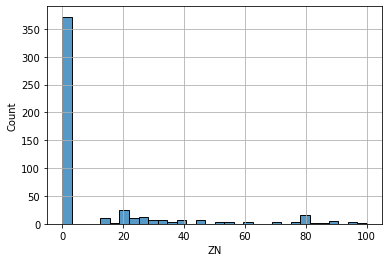

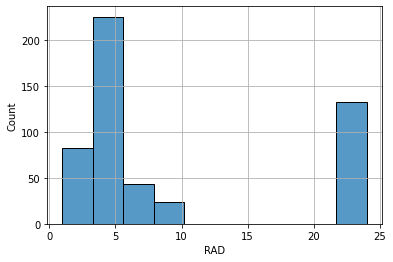

In [ ]:
get_hist(data,['ZN','RAD'])

## Работа с выбросами

Представим графически исследование на выбросы:

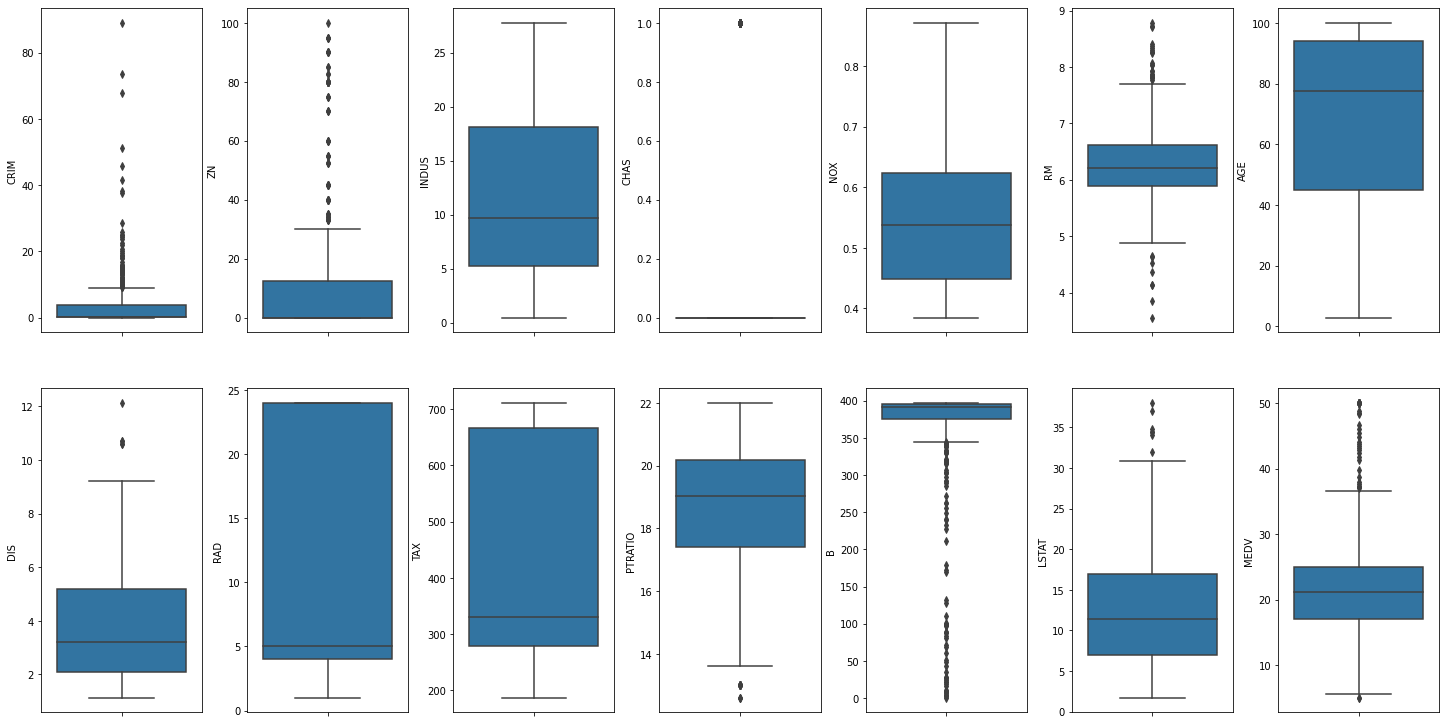

In [ ]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
  sns.boxplot(y=k, data=data, ax=axs[index])
  index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Заметим, как много выбросов в таких полях как CRIM, ZN, B. И самое интересное - что выбросы есть в нашей целевой переменной. В описаниях этого датасета пишут, что данные по переменной MEDV подверглись ограничению по "потолку" = 50.
Посмотрим на неё и убедимся в этом: 

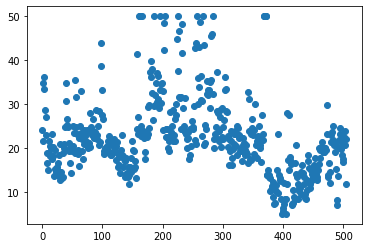

In [ ]:
plt.scatter(data.index,data.MEDV)

In [ ]:
len(data[data.MEDV==50])

16

Действительно, наблюдается в верхней части своеобразный потолок. Это значит, что значения MEDV = 50, на самом деле  могут быть неопределенно выше, и предсказать эти значения по информации из датасета не представляется возможным, и значит это точки из данных необходимо убрать:

In [ ]:
data = data[data['MEDV'] < 50.0]
data.shape

(490, 14)

Посмотрим теперь качество линейной регрессии:

In [ ]:
get_score(data.drop('MEDV', axis = 1), data['MEDV'])

0.7538446825846035

## Features

Продолжим исследование. Построим матрицу корреляции:

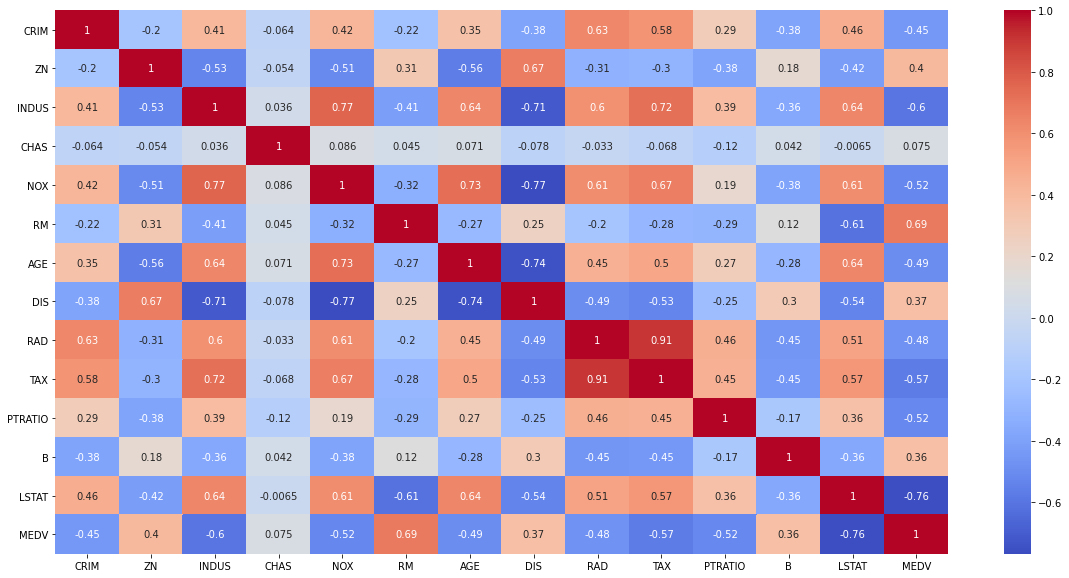

In [ ]:
plt.figure(figsize=(20, 10))
get_heatmap(data)

Анализ корреляции показывает тесную статистическую связь между переменными RAD и TAX, поэтому один из столбцов нужно убрать.
Кроме того, заметим, в поиске переменных для предсказания - какие переменные показывают корреляцию > 0.5 с целевой переменной, а именно:

LSTAT, RM, INDUS, TAX(RAD), NOX, PTRATIO

оставляем только переменные, у которых корреляция с целевой переменной выше 0.5:

In [ ]:
data = data[['LSTAT', 'RM', 'INDUS', 'TAX', 'NOX', 'PTRATIO', 'MEDV']]

In [ ]:
get_score(data.drop('MEDV', axis = 1), data['MEDV'])

0.7268061311892826

## Шкалирование

In [ ]:
X = data.copy()
X.loc[:,:] = preprocessing.StandardScaler().fit_transform(X)

In [ ]:
get_score(X.drop('MEDV', axis = 1), X['MEDV'])

0.7268061311892832

Качество модели никак не изменилось - жаль, были надежды

## Конструирование переменных

Отрисуем графики корреляций:

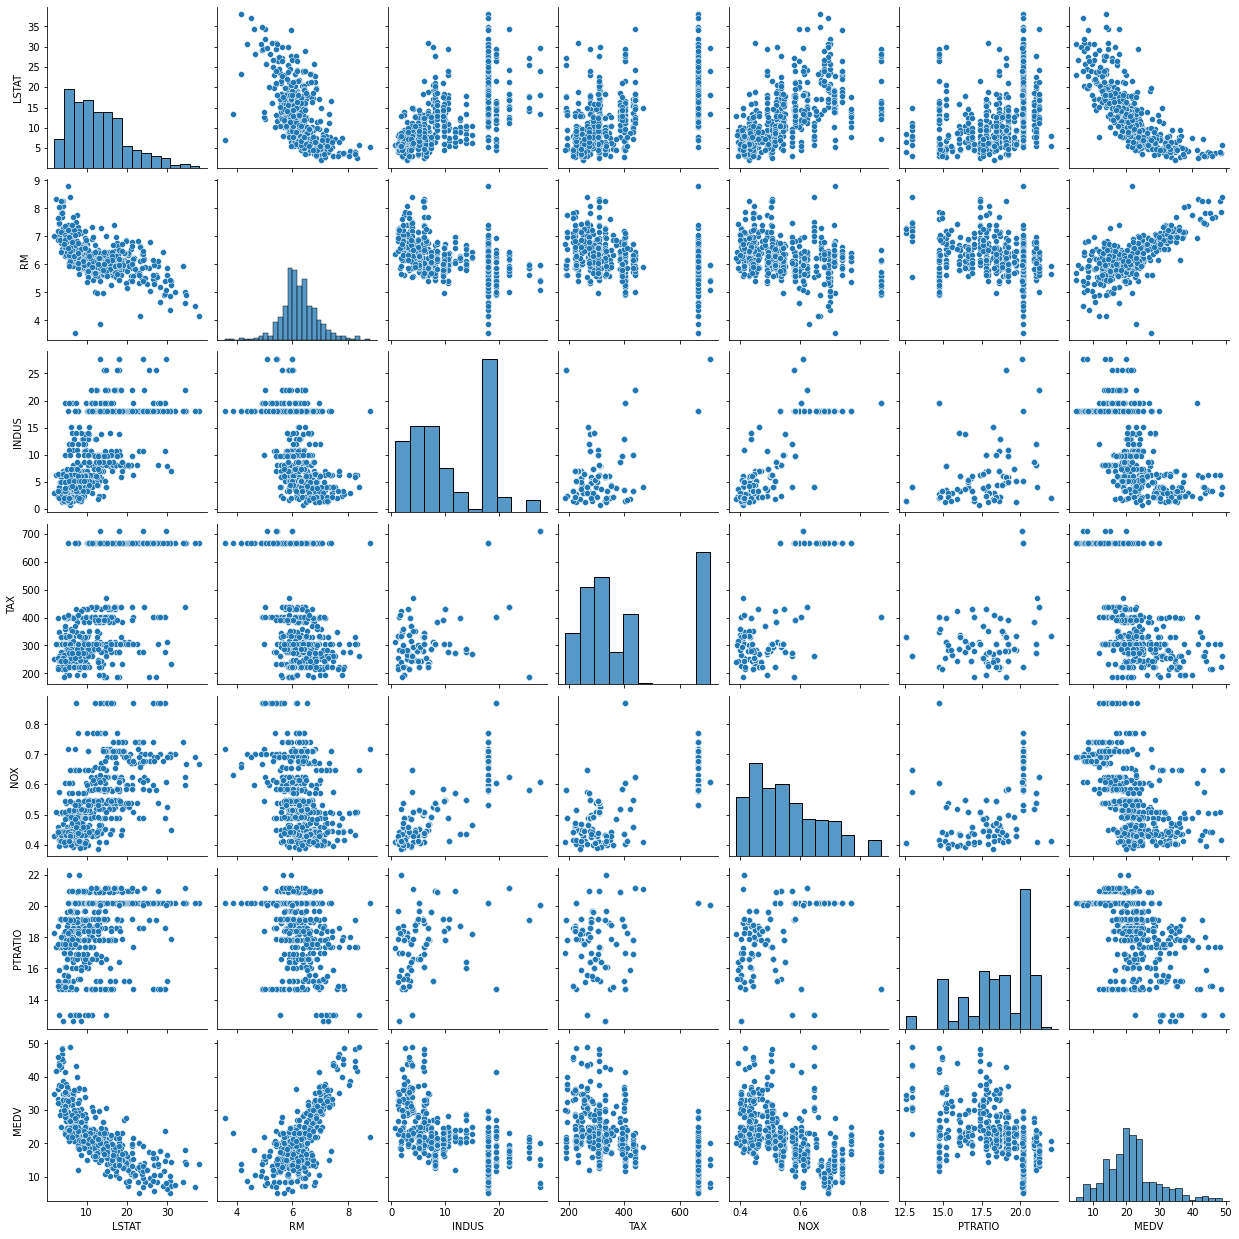

In [ ]:
get_pairplot(data)

Что здесь можно заметить? —
Что у целевой переменной MEDV - устойчивая линейная зависимость от переменной RM, и нелинейная зависимость от переменной LSTAT, похожей на гиперболу.

Добавим в наш датасет две новых перемнных:
— произведение RM * LSTAT
- отношение RM / LSTAT

и уберем исходные переменные RM, LSTAT:

In [ ]:
data1 = data.copy()
data1['mult'] = data['RM'] * data['LSTAT']
data1['divide'] = data['RM'] / data['LSTAT']
data1 = data1.drop(['RM','LSTAT'], axis = 1)

In [ ]:
get_score(data1.drop('MEDV', axis = 1), data1['MEDV'])

0.7513370364606907

Как видно, результат еще немного улучшился.
На этот момент решение меня хоть и не устраивает, но надо заканчивать.

Но прежде применим к получившемуся датасету модель Случайного леса, для иллюстрации потенциала дальнейшей достигаемой точности:

# Деревья

In [ ]:
X = data1.drop('MEDV', axis = 1)
y = data1['MEDV']

Проведем на всякий случай шкалирование

In [ ]:
X.loc[:,:] = preprocessing.StandardScaler().fit_transform(X)
y = (y - y.mean())/y.std()

обучаем случайный лес

In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf_rf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X, y)
clf_rf.score(X,y)

0.7871752068395879

И выведем важность переемнных:

In [ ]:
for i,j in enumerate(clf_rf.feature_importances_):
  print(X.columns[i], round(j,7))

INDUS 0.0891954
TAX 0.0214775
NOX 0.0457785
PTRATIO 0.0404317
mult 0.2931015
divide 0.5100153


# Результат (R2 для линейной регрессии)

- Базовое решение линейной регрессией (все фичи без обработки)
0.7112260057484903
- После удаления выбросов MEDV
0.7538446825846035
- После выбора фичей
0.7268061311892826
- После создания переменных
0.7513370364606907
- Рандом форест: 
0.7871752068395879